In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip
from scipy import signal
from scipy.constants import hbar
from scipy.linalg import expm
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm

# Qubit evolution in the lab frame

Define the Pauli matrices

$\sigma_z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$ $\sigma_x = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$ $\sigma_y = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}$

In [2]:
sigmaZ = np.array([[1,0],
                   [0,-1]])
sigmaX = np.array([[0,1],
                   [1,0]])
sigmaY = np.array([[0,-1j],
                   [1j,0]])

Define the Hamiltonian $\mathcal{H} = \frac{\hbar}{2} \omega \sigma_z$

In [ ]:
omega = 2 * np.pi

H = hbar/2 * omega * sigmaZ
print(H)

Define an initial state $| \psi_0 \rangle = c_0 \begin{pmatrix} 1 \\ 0 \end{pmatrix} + c_1 \begin{pmatrix} 0 \\ 1 \end{pmatrix}$

In [ ]:
# psi0 = np.array([1,0])
psi0 = np.array([1,1])*1/np.sqrt(2)
print(psi0)

Evolve the state in time using $| \psi_t \rangle = U(t) | \psi_0 \rangle$ with $U(t) = e^{\frac{-i \mathcal{H} t}{\hbar}}$

In [ ]:
time = np.linspace(0,0.95,96)
psiT = []

for t in time:
    psiT.append(expm(-1j*H*t/hbar) @ psi0)

Save the expectation values of x, y and z (e.g. $\langle \psi_t | \sigma_z | \psi_t \rangle$)

In [ ]:
x = [(p.conj().T @ sigmaX @ p).real for p in psiT]
y = [(p.conj().T @ sigmaY @ p).real for p in psiT]
z = [(p.conj().T @ sigmaZ @ p).real for p in psiT]

Plot the evolution of the state

In [6]:
def qubitPlots(time,x,y,z):
    bsPlot = qutip.Bloch()
    bsPlot.add_points([x, y, z])
    bsPlot.render()
    bsPlot.fig.set_size_inches([25,5])

    ax1 = bsPlot.fig.add_subplot(133)
    ax1.plot(time,x,label="x")
    ax1.plot(time,y,label="y")
    ax1.plot(time,z,label="z")
    ax1.legend()
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Expectation value")
    bsPlot.show()

In [ ]:
qubitPlots(time,x,y,z)

Let's add a drive term $\mathcal{H} = \frac{\hbar}{2} \left( \omega \sigma_z + \Omega \cos \left( \omega t \right) \sigma_x \right)$

In [ ]:
omegaStatic = 20 * np.pi
omegaDrive = 2 * np.pi

H = lambda t: hbar / 2 * (omegaStatic * sigmaZ + omegaDrive * np.cos(omegaStatic * t) * sigmaX)

With a time-dependent Hamiltonian, we need to evolve step-by-step

In [ ]:
psi0 = np.array([1,0])

time = np.linspace(0,1,1001)
dTime = time[1] - time[0]
psiT = []

for t in time:
    if t == 0:
        psiT.append(psi0)
    else:
        psiT.append(expm(-1j*H(t)*dTime/hbar) @ psiT[-1])
    
x = [(p.conj().T @ sigmaX @ p).real for p in psiT]
y = [(p.conj().T @ sigmaY @ p).real for p in psiT]
z = [(p.conj().T @ sigmaZ @ p).real for p in psiT]

In [ ]:
qubitPlots(time,x,y,z)

# Qubit evolution in the rotating frame

Define the Hamiltonian $\mathcal{H} = \frac{\hbar}{2} ( \Delta \sigma_z + \Omega_x \sigma_x + \Omega_y \sigma_y )$

In [ ]:
delta = 0 # 4 * np.pi
omegaX = 2 * np.pi
omegaY = 0 * np.pi

H = hbar/2 * ( delta*sigmaZ + omegaX*sigmaX + omegaY*sigmaY )
print(H)

Define an initial state and evolve in time

In [ ]:
psi0 = np.array([1,0])

time = np.linspace(0,0.95,96)
dTime = time[1] - time[0]
psiT = []

for t in time:
    if t == 0:
        psiT.append(psi0)
    else:
        psiT.append(expm(-1j*H*dTime/hbar) @ psiT[-1])
    
x = [(p.conj().T @ sigmaX @ p).real for p in psiT]
y = [(p.conj().T @ sigmaY @ p).real for p in psiT]
z = [(p.conj().T @ sigmaZ @ p).real for p in psiT]

In [ ]:
qubitPlots(time,x,y,z)

Let's add a detuning axis now

In [ ]:
psi0 = np.array([1,0])

time = np.linspace(0,3,301)
dTime = time[1] - time[0]

detunings = np.linspace(-4*np.pi, 4*np.pi, 51)
psiT = []
z = np.zeros([len(detunings),len(time)])

for iDet, delta in enumerate(detunings):
    H = hbar/2 * ( delta*sigmaZ + omegaX*sigmaX + omegaY*sigmaY )
    for iTime, t in enumerate(time):
        if t == 0:
            psiT.append(psi0)
        else:
            psiT.append(expm(-1j*H*dTime/hbar) @ psiT[-1])
            z[iDet, iTime] = (psiT[-1].conj().T @ sigmaZ @ psiT[-1]).real

In [ ]:
plt.pcolormesh(time, detunings, z, shading="nearest")
plt.xlabel("Time")
plt.ylabel("Detuning")

# Qubit decoherence

## Dephasing noise

Noise that modulates the qubit splitting (i.e. along the quantization axis). In most cases, this noise is pink. Let's create an array sampled from a spectrum $S_N = \frac{S_0}{\omega}$, and add it to the detuning term in the Hamiltonian.

In [3]:
N = 1001
fs = 1000
wNoise = np.random.normal(0,50,N)
b,a = signal.butter(1, [0.01, 0.5], btype="band", fs=fs)
pNoise = signal.lfilter(b,a,wNoise)

H_noise = lambda n: hbar/2 * (n * sigmaZ)

Start with a superposition state and evolve our noisy Hamiltonian

In [4]:
psi0 = np.array([1,1])*1/np.sqrt(2)

time = np.linspace(0,0.95,N)
dTime = 1 / fs
psiT = []

for t,n in zip(time,pNoise):
    if t == 0:
        psiT.append(psi0)
    else:
        psiT.append(expm(-1j*H_noise(n)*dTime/hbar) @ psiT[-1])
    
x = [(p.conj().T @ sigmaX @ p).real for p in psiT]
y = [(p.conj().T @ sigmaY @ p).real for p in psiT]
z = [(p.conj().T @ sigmaZ @ p).real for p in psiT]

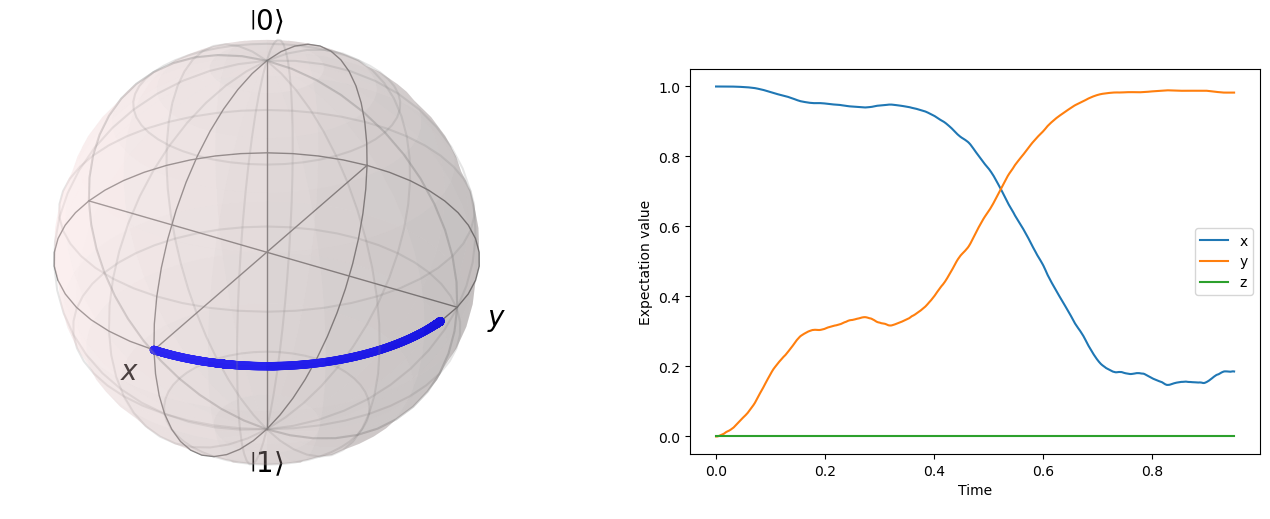

In [7]:
qubitPlots(time,x,y,z)

## Characterising and decoupling dephasing noise

### Ramsey fringes - $T_2^*$
##### $\frac{\pi}{2} - \tau - \frac{\pi}{2} - \textrm{M}$

In this experiment we apply a $\pi / 2$ gate to prepare the spin on the x-y plane of the Bloch sphere, wait some time $\tau$ and apply another $\pi / 2$ gate to attempt to bring the spin back to the quantization axis.

When we perform this experiment on a qubit, we need to repeat the pulse sequence many times to build up statistics on the single-shot measurements. We will capture that by adding a repetition loop to the simulation.

In the simulation of this pulse sequence, we assume that we can apply a perfect $\pi / 2$ gate, and apply the unitary directly.

In [8]:
X_2 = (sigmaX + sigmaZ) / np.sqrt(2) # This defines the unitary of a pi/2 gate
psi0 = X_2 @ np.array([1,0]) # First pi/2 pulse on the initialised state

# We can play with two terms on the Hamiltonian, a static detuning and a time-dependent noise on the qubit splitting
H_det = hbar/2 * (2*np.pi * sigmaZ)
H_noise = lambda n: hbar/2 * (n * sigmaZ)

# Define the sampling frequency, the Ramsey wait times, the number of measurements to perform and noise amplitude
fs = 1000
taus = np.linspace(0.01, 5, int(5/0.01))
reps = 100
noise_amp = 30

# Generate an array of pink noise
dTime = 1 / fs
tauPoints = int(taus[0] / dTime)
N = int(taus[-1] / dTime) * reps
wNoise = np.random.normal(0,noise_amp,N)
b,a = signal.butter(1, [0.01, 0.5], btype="band", fs=fs)
pNoise = signal.lfilter(b,a,wNoise)

# Start simulation
zTau = np.zeros((reps, len(taus)))
for r in tqdm(range(reps)):
    psiT = [psi0] # Initialise the state at the start of each measurement
    for i, tau in enumerate(taus):
        for j in range(tauPoints):
            nIdx = r * len(taus) + i * tauPoints + j
            psiT.append(expm(-1j*(H_noise(pNoise[nIdx]) + H_det)*dTime/hbar) @ psiT[-1])
        # Apply the second pi/2 gate and measure along z after each tau interval
        psiRamsey = X_2 @ psiT[-1]
        zTau[r,i] = (psiRamsey.conj().T @ sigmaZ @ psiRamsey).real

  0%|          | 0/100 [00:00<?, ?it/s]

Now let's visualise the data. Let's first plot the bare data to give you a chance to try to think about what it means...

(-1.0, 1.0)

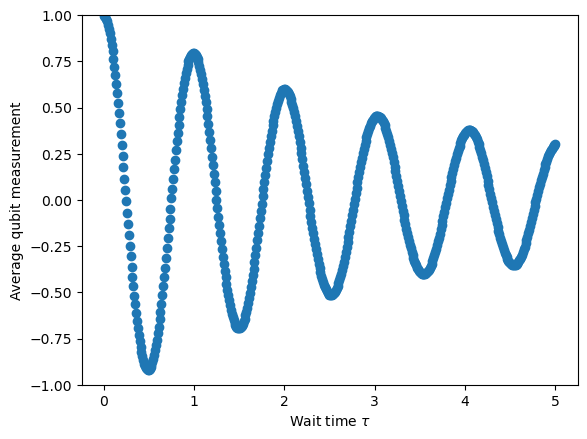

In [9]:
plt.plot(taus, np.mean(zTau, axis=0), 'o')
plt.ylabel("Average qubit measurement")
plt.xlabel(r"Wait time $\tau$")
plt.ylim([-1,1])

Notice that there are two characteristic features in the data. A single _frequency_ and an exponential _decay_.

The frequency corresponds to the detuning frequency (i.e. the difference between the qubit frequency and the frequency of the rf source). 
In traditional NMR measurements which may be performed on samples with several spin species (different molecules), the spectrum of the Ramsey signal can be used to identify which molecules are present.
In qubits, it can be used for a coarse calibration of the qubit frequency.

The decay time is known as $T_2^*$ (also sometimes known as _free induction decay_) and it provides an initial characterisation of the environmental noise that couples to the energy splitting of the qubit, a.k.a. _dephasing noise_.

To extract these two important parameters, we can fit our data to a function of the form:

$\langle \sigma_Z \rangle \left( \tau \right) = A \cos \left( \omega \tau \right) e^{-\tau / T_2^*}$

In [10]:
# Define the fitting function
def t2_star_decay(time, amplitude, omega, decay):
    return amplitude * np.cos(omega * time) * np.exp(-time / decay)

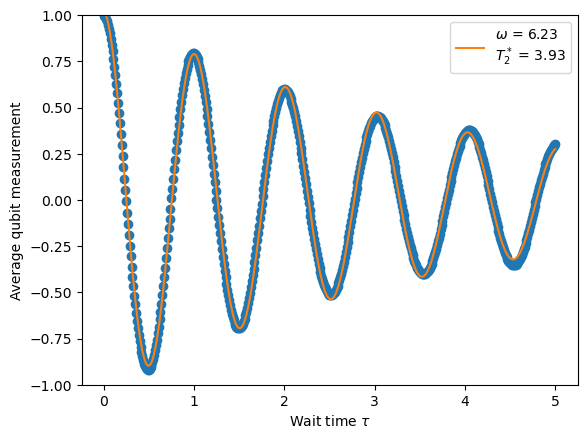

In [11]:
#Fit the data using the function previously defined
popt,_ = curve_fit(t2_star_decay, taus, np.mean(zTau, axis=0))

# Plot data and function with extracted parameters
plt.plot(taus, np.mean(zTau, axis=0), 'o')
plt.plot(taus, t2_star_decay(taus, *popt), label=rf"$\omega$ = {popt[1]:.2f}"+"\n"+rf"$T_2^*$ = {popt[2]:.2f}")
plt.ylabel("Average qubit measurement")
plt.xlabel(r"Wait time $\tau$")
plt.ylim([-1,1])
plt.legend()

### Hahn echo - $T_2$
##### $\frac{\pi}{2} - {\footnotesize \tau / 2} - \pi - {\footnotesize \tau / 2} - \frac{\pi}{2} - \textrm{M}$

Over short time scales, the pink dephasing noise looks like a constant detuning, i.e., a constant drift in the phase of the qubit. A constant drift can be _refocussed_ by adding a $\pi$ gate in the middle of our wait time.
Try to think about what this does to the qubit on the Bloch sphere before running the simulation...

In [24]:
X = sigmaX # This defines the unitary of a pi gate
psi0 = X_2 @ np.array([1,0]) # First pi/2 pulse on the initialised state

# We can now set the detuning to 0, since it will get refocussed anyway
H_det = 0 #hbar/2 * (2*np.pi * sigmaZ)
H_noise = lambda n: hbar/2 * (n * sigmaZ)

# Define the sampling frequency, the Ramsey wait times, the number of measurements to perform and noise amplitude
fs = 1000
taus = np.linspace(0.01, 10, int(10/0.01))
reps = 100
noise_amp = 3000

# Generate an array of pink noise
dTime = 1 / fs
tauPoints = int(taus[0] / dTime)
N = int(taus[-1] / dTime) * reps
wNoise = np.random.normal(0,noise_amp,N)
b,a = signal.butter(1, [0.01, 0.5], btype="band", fs=fs)
pNoise = signal.lfilter(b,a,wNoise)

# Start simulation
zTau = np.zeros((reps, len(taus)))
for r in tqdm(range(reps)):
    psiT = [psi0] # Initialise the state at the start of each measurement
    for i, tau in enumerate(taus):
        for j in range(tauPoints):
            nIdx = r * len(taus) + i * tauPoints + j
            if j == int(tauPoints / 2): # At the half-way point, add an X-gate after the evolution
                psiT.append(X @ expm(-1j*(H_noise(pNoise[nIdx]) + H_det)*dTime/hbar) @ psiT[-1])
            else:
                psiT.append(expm(-1j*(H_noise(pNoise[nIdx]) + H_det)*dTime/hbar) @ psiT[-1])
        # Apply the second pi/2 gate and measure along z after each tau interval
        psiRamsey = X_2 @ psiT[-1]
        zTau[r,i] = (psiRamsey.conj().T @ sigmaZ @ psiRamsey).real

  0%|          | 0/100 [00:00<?, ?it/s]

Now let's plot the data from this pulse sequence

(-1.0, 1.0)

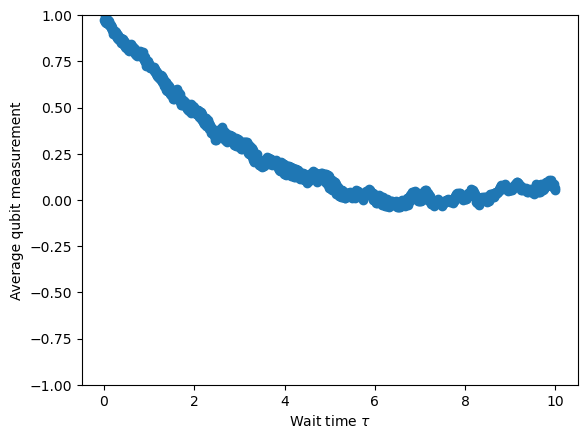

In [25]:
plt.plot(taus, np.mean(zTau, axis=0), 'o')
plt.ylabel("Average qubit measurement")
plt.xlabel(r"Wait time $\tau$")
plt.ylim([-1,1])